In [41]:
import uproot as uproot# reading ROOT filies
import mplhep as hep # matplotlib for hep
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import awkward as ak 

# path to the root files
path = '/work/projects/PHYS565/data/'

# configuration -- convention used, first sample is Data, the rest are MCs
filenames = ['data.root', 'wjets.root', 'dy.root',  'ttbar.root', 'ww.root',  'wz.root', 'zz.root', 'single_top.root', 'qcd.root']
labels = ['Data', 'WJets',   'DYJets', 'TTbar',   'WW',     'WZ',     'ZZ',      'Single Top','QCD']
colors = ["white","#79b278", "#f0f423", "#ff0000","#6b59d3", "orange", "#baff8d", "#00cdff"  , "#a9a9a9"]

TTreeName = 'events'
EventWeightBranchName = 'EventWeight' 

# set CMS plot style    
plt.style.use([hep.style.ROOT, hep.style.firamath])

# read all dataframes as awkward arrays https://awkward-array.readthedocs.io/en/stable/#    
dfs = [uproot.lazy(path+filename+':'+TTreeName) for filename in filenames]

# print out number of events found in each dataframe
for i in range(len(dfs)):
    if len(dfs) == len(labels) == len(colors):
        dfs[i].label = labels[i]
        dfs[i].color = colors[i]
        print('opened %s with %d entries as %s'%(filenames[i], len(dfs[i]), dfs[i].label))
    else: print('length of dfs, labels and colors are not equal, please fix and re-run')

opened data.root with 469384 entries as Data
opened wjets.root with 109737 entries as WJets
opened dy.root with 77729 entries as DYJets
opened ttbar.root with 36941 entries as TTbar
opened ww.root with 4580 entries as WW
opened wz.root with 3367 entries as WZ
opened zz.root with 2421 entries as ZZ
opened single_top.root with 5684 entries as Single Top
opened qcd.root with 142 entries as QCD


In [2]:
# reorder dataframes (optional) 
for i, df in enumerate(dfs):
    print('i = %d [%s]'%(i,df.label))

neworder = [0, 8, 1, 7, 4, 3, 5, 6, 2]

print('')
print('reordering dfs using these indexes', neworder)
print('')

reordered_dfs = [ dfs[neworder[i]] for i in range(len(dfs))]
for i, df in enumerate(reordered_dfs):
    print('i = %d [%s]'%(i,df.label))

# setting dfs to its new order
dfs = reordered_dfs

i = 0 [Data]
i = 1 [WJets]
i = 2 [DYJets]
i = 3 [TTbar]
i = 4 [WW]
i = 5 [WZ]
i = 6 [ZZ]
i = 7 [Single Top]
i = 8 [QCD]

reordering dfs using these indexes [0, 8, 1, 7, 4, 3, 5, 6, 2]

i = 0 [Data]
i = 1 [QCD]
i = 2 [WJets]
i = 3 [Single Top]
i = 4 [WW]
i = 5 [TTbar]
i = 6 [WZ]
i = 7 [ZZ]
i = 8 [DYJets]


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import awkward as ak

def makePlot(dfs, var, xmin=0, xmax=5, step_size=1, ylog=False, saveFig=False, xlabel='', ylabel='', printOut=True, plot_ratio=True):
    plotMCstack = len(dfs) >= 2

    labels = [df.label for df in dfs]
    colors = [df.color for df in dfs]

    bin_edges = np.arange(start=xmin, stop=xmax + step_size, step=step_size)
    bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2

    for df in dfs:
        df.weights = ak.to_numpy(df['EventWeight'])
        df.histoEntries = ak.to_numpy(df[var]).flatten()
        df.histo = np.histogram(df.histoEntries, bins=bin_edges, weights=df.weights)[0]
        df.histoError = np.sqrt(np.histogram(df.histoEntries, bins=bin_edges, weights=df.weights**2)[0])

    if plot_ratio and plotMCstack:
        fig = plt.figure(figsize=(6, 8))
        gs = GridSpec(2, 1, height_ratios=[3, 1], hspace=0.05)
        ax_main = fig.add_subplot(gs[0])
        ax_ratio = fig.add_subplot(gs[1])
    else:
        fig, ax_main = plt.subplots(figsize=(6, 6))

    if plotMCstack:
        mcHistosEntries = [df.histoEntries for df in dfs[1:]]
        mcHistosWeights = [df.weights for df in dfs[1:]]
        mcHistoStack = ax_main.hist(mcHistosEntries, bins=bin_edges, weights=mcHistosWeights, 
                                    stacked=True, label=labels[1:], color=colors[1:], alpha=0.8)[0]
        mcHistoTot = mcHistoStack[-1]
        mcHistoTotError = np.sqrt(np.histogram(
            np.hstack(mcHistosEntries), bins=bin_edges, weights=np.hstack(mcHistosWeights)**2)[0])

        ax_main.step(bin_edges[:-1], mcHistoTot, where='post', color='black', linestyle='-', linewidth=3, label='Total')
        ax_main.fill_between(bin_edges[:-1], mcHistoTot - mcHistoTotError, mcHistoTot + mcHistoTotError,
                              step='post', color='black', alpha=0.5, hatch='//////', label='Stat. Unc.')

    ax_main.errorbar(bin_centres, dfs[0].histo, yerr=dfs[0].histoError, fmt='o', color='black', capsize=4, capthick=1, markersize=8, label=labels[0])

    ax_main.set_xlabel('' if plot_ratio else (xlabel if xlabel else var), fontsize=18, loc='right')
    ax_main.set_ylabel(rf'{ylabel if ylabel else "Events / bin"}', fontsize=18, loc='top')
    ax_main.set_yscale('log' if ylog else 'linear')
    ax_main.set_xlim(xmin, xmax)
    ax_main.tick_params(axis='both', which='major', labelsize=16, direction='in', length=8, width=1.5)
    ax_main.tick_params(axis='both', which='minor', labelsize=12, direction='in', length=4, width=1.0)
    #ax_main.legend(fontsize=12, loc='upper right', frameon=False, ncol=1)
    
        # --- Reorder and display legend properly ---
    handles, legend_labels = ax_main.get_legend_handles_labels()

    preferred_order = ['Data', 'Total', 'Stat. Unc.',
                       'QCD', 'WJets', 'Single Top', 'WW', 'TTbar', 'WZ', 'ZZ', 'DYJets']

    # Create ordered lists based on preferred legend order
    ordered_handles = []
    ordered_labels = []

    for label in preferred_order:
        if label in legend_labels:
            idx = legend_labels.index(label)
            ordered_handles.append(handles[idx])
            ordered_labels.append(label)

    ax_main.legend(
        ordered_handles,
        ordered_labels,
        fontsize=12,
        loc='upper left',
        bbox_to_anchor=(1.02, 1.0),  # place legend outside the plot
        borderaxespad=0,
        frameon=False,
        ncol=1
    )

    if plot_ratio and plotMCstack:
        ratio = np.divide(dfs[0].histo, mcHistoTot, out=np.zeros_like(dfs[0].histo, dtype=float), where=mcHistoTot != 0)
        ratio_errors = np.divide(dfs[0].histoError, mcHistoTot, out=np.zeros_like(dfs[0].histoError, dtype=float), where=mcHistoTot != 0)

        ax_ratio.errorbar(bin_centres, ratio, yerr=ratio_errors, fmt='o', color='black', capsize=4, capthick=1, markersize=8)
        ax_ratio.axhline(1, color='red', linestyle='--', linewidth=1)
        ax_ratio.set_xlim(xmin, xmax)
        ax_ratio.set_ylim(0.1, 1.9)
        ax_ratio.set_xlabel(rf'{xlabel if xlabel else var}', fontsize=18, loc='right')
        ax_ratio.set_ylabel('Data / MC', fontsize=14, loc='center')
        ax_ratio.grid(visible=True, which='both', linestyle='--', linewidth=0.5)
        ax_ratio.tick_params(axis='both', which='major', labelsize=16, direction='in', length=8, width=1.5)
        ax_ratio.tick_params(axis='both', which='minor', labelsize=12, direction='in', length=4, width=1.0)
        ax_main.tick_params(axis='x', which='both', labelbottom=False)

    if saveFig:
        plt.savefig(f"{var}.pdf")
        plt.savefig(f"{var}.png")

    plt.show()

    # Summary and event totals
    Data = sum(dfs[0].histo)
    DataError = sum(dfs[0].histoError**2)**0.5
    print(f'Data: {Data:.1f} ± {DataError:.1f} [entries: {len(dfs[0])}]')

    if plotMCstack:
        MC = sum(mcHistoTot)
        MCError = sum(mcHistoTotError**2)**0.5
        print(f'MC  : {MC:.1f} ± {MCError:.1f} [entries: {sum(len(df) for df in dfs[1:])}]')

    for df in dfs:
        df.totEvents = sum(df.histo)
        df.totEventsError = sum(df.histoError**2)**0.5

    print('-----------------------------')
    for df in dfs[1:]:
        print(f'{df.label}  {df.totEvents:.1f} ± {df.totEventsError:.1f}  [entries: {len(df)}]')
    print('-----------------------------')

    if printOut:
        print('\n### printing number of events for each bin and its estimated uncertainty ###\n')
        for df in dfs[0:1]:
            print(f'{df.label} = {[f"{v:.1f}" for v in df.histo]}')
            print(f'{df.label}Error = {[f"{v:.1f}" for v in df.histoError]}')

        if plotMCstack:
            print('MCTot =', [f'{v:.1f}' for v in mcHistoTot])
            print('MCTotError =', [f'{v:.1f}' for v in mcHistoTotError])
            print('\n### detailed analysis of MC ###\n')
            for df in dfs[1:]:
                print(f'{df.label} = {[f"{v:.1f}" for v in df.histo]}')
                print(f'{df.label}Error = {[f"{v:.1f}" for v in df.histoError]}')


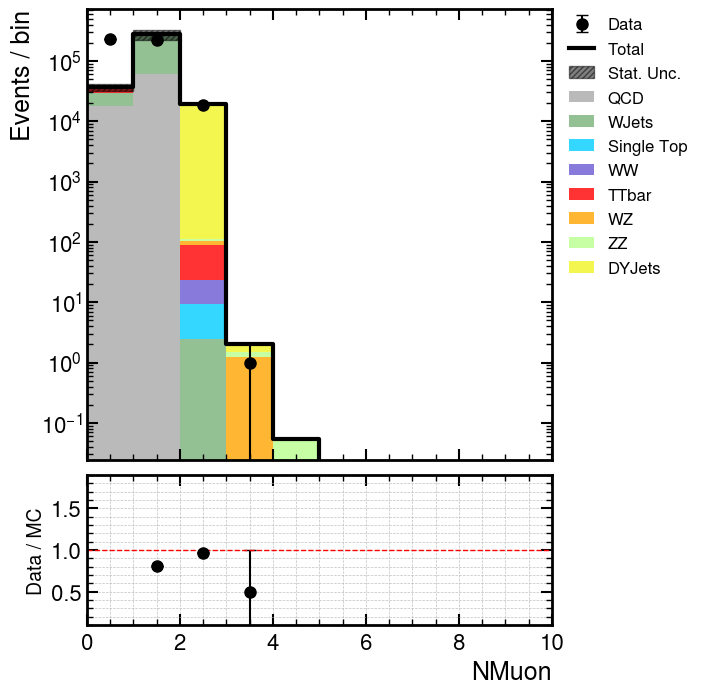

Data: 469384.0 ± 685.1 [entries: 469384]
MC  : 331407.3 ± 55460.8 [entries: 240601]
-----------------------------
QCD  79160.5 ± 55457.2  [entries: 142]
WJets  209576.7 ± 689.2  [entries: 109737]
Single Top  311.6 ± 4.4  [entries: 5684]
WW  229.9 ± 3.7  [entries: 4580]
TTbar  7928.6 ± 45.5  [entries: 36941]
WZ  69.9 ± 1.3  [entries: 3367]
ZZ  16.9 ± 0.4  [entries: 2421]
DYJets  34113.2 ± 145.6  [entries: 77729]
-----------------------------

### printing number of events for each bin and its estimated uncertainty ###

Data = ['227265.0', '223411.0', '18707.0', '1.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']
DataError = ['476.7', '472.7', '136.8', '1.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']
MCTot = ['36534.6', '275505.5', '19365.2', '2.0', '0.1', '0.0', '0.0', '0.0', '0.0', '0.0']
MCTotError = ['5041.7', '55231.1', '103.7', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']

### detailed analysis of MC ###

QCD = ['18058.3', '61102.2', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0'

In [4]:
# plot muon multiplicity without any event selection
makePlot(dfs, var='NMuon', xmin = 0, xmax = 10, ylog = True, saveFig = True)

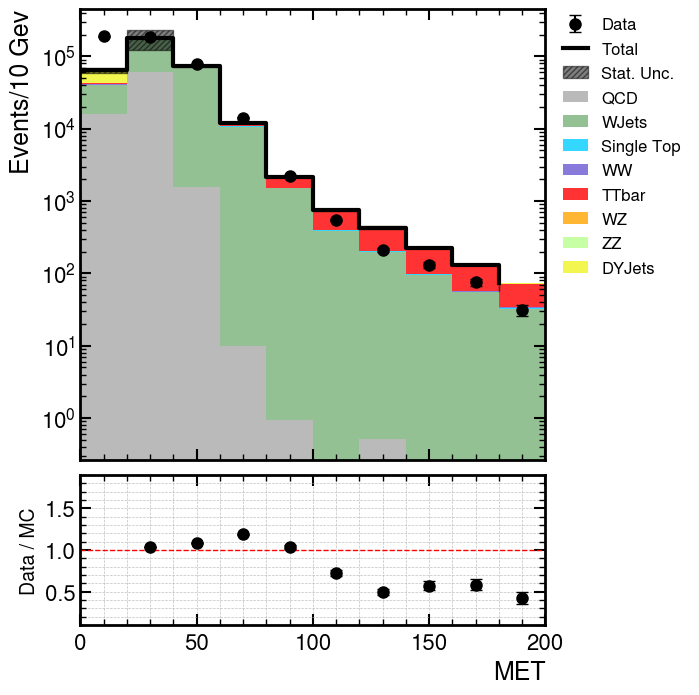

Data: 469319.0 ± 685.1 [entries: 469384]
MC  : 331282.1 ± 55460.1 [entries: 240601]
-----------------------------
QCD  79160.5 ± 55457.2  [entries: 142]
WJets  209522.8 ± 689.1  [entries: 109737]
Single Top  309.9 ± 4.4  [entries: 5684]
WW  229.3 ± 3.7  [entries: 4580]
TTbar  7860.8 ± 45.3  [entries: 36941]
WZ  69.7 ± 1.3  [entries: 3367]
ZZ  16.8 ± 0.4  [entries: 2421]
DYJets  34112.2 ± 145.6  [entries: 77729]
-----------------------------

### printing number of events for each bin and its estimated uncertainty ###

Data = ['188170.0', '185028.0', '78621.0', '14262.0', '2242.0', '547.0', '212.0', '130.0', '76.0', '31.0']
DataError = ['433.8', '430.1', '280.4', '119.4', '47.3', '23.4', '14.6', '11.4', '8.7', '5.6']
MCTot = ['63920.4', '179057.1', '72493.3', '12029.0', '2170.2', '754.7', '427.2', '226.8', '130.2', '73.3']
MCTotError = ['5344.6', '55195.5', '835.4', '99.9', '39.2', '16.0', '22.6', '0.0', '0.0', '16.0']

### detailed analysis of MC ###

QCD = ['16133.9', '61451.6', '1563

In [5]:
for df in dfs:
    df['MET'] = np.sqrt(df["MET_px"]**2 + df["MET_py"]**2)

makePlot(dfs, var="MET", xmin=0, xmax=200, step_size=20, ylabel='Events/10 Gev', ylog = True, saveFig = False)

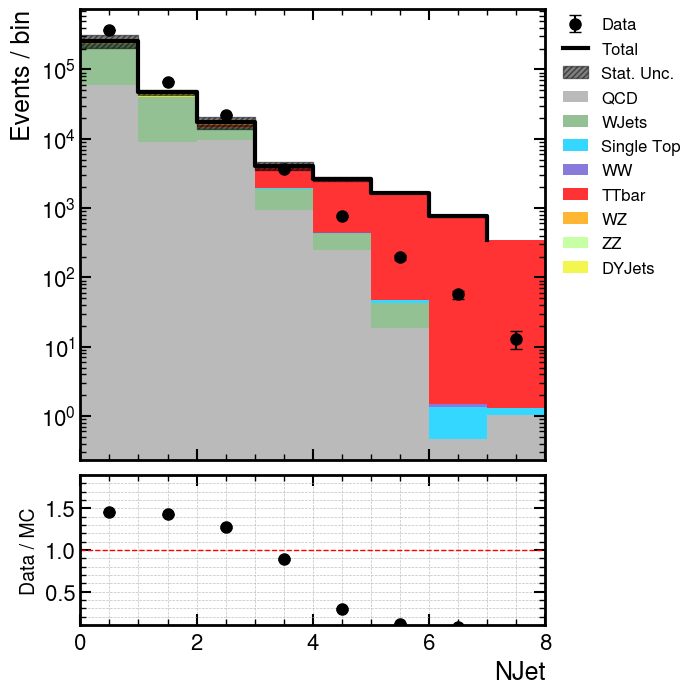

Data: 469382.0 ± 685.1 [entries: 469384]
MC  : 331378.8 ± 55460.9 [entries: 240601]
-----------------------------
QCD  79160.5 ± 55457.2  [entries: 142]
WJets  209573.0 ± 689.2  [entries: 109737]
Single Top  311.6 ± 4.4  [entries: 5684]
WW  229.9 ± 3.7  [entries: 4580]
TTbar  7903.4 ± 45.4  [entries: 36941]
WZ  69.9 ± 1.3  [entries: 3367]
ZZ  16.9 ± 0.4  [entries: 2421]
DYJets  34113.5 ± 145.6  [entries: 77729]
-----------------------------

### printing number of events for each bin and its estimated uncertainty ###

Data = ['375818.0', '66967.0', '21919.0', '3643.0', '770.0', '195.0', '57.0', '13.0']
DataError = ['613.0', '258.8', '148.1', '60.4', '27.7', '14.0', '7.5', '3.6']
MCTot = ['257806.5', '46908.4', '17194.7', '4095.8', '2610.4', '1660.0', '761.7', '341.3']
MCTotError = ['55220.9', '3821.8', '3414.0', '520.2', '185.9', '22.6', '22.6', '0.0']

### detailed analysis of MC ###

QCD = ['59425.7', '8919.8', '9592.9', '954.6', '247.2', '18.7', '0.5', '1.0']
QCDError = ['55217.5', 

In [6]:
makePlot(dfs, var='NJet', xmin = 0, xmax = 8, ylog = True, saveFig = False)

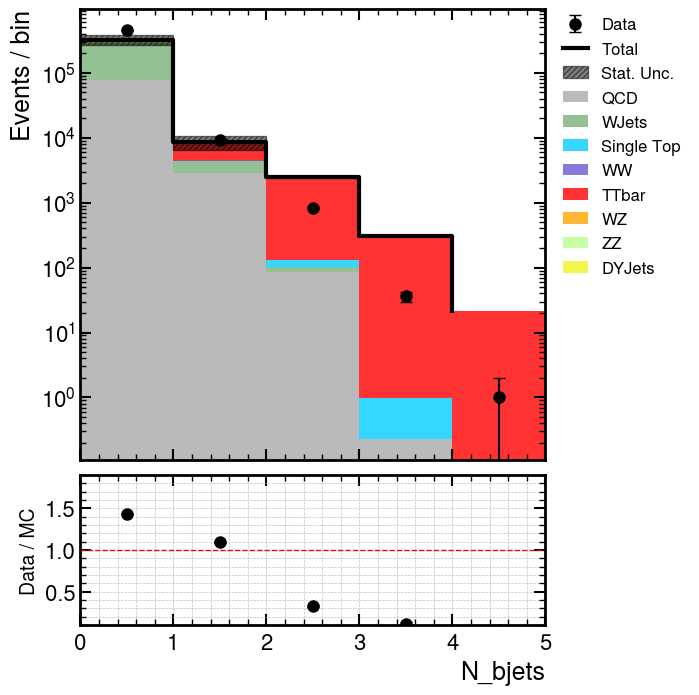

Data: 469384.0 ± 685.1 [entries: 469384]
MC  : 331406.7 ± 55460.8 [entries: 240601]
-----------------------------
QCD  79160.5 ± 55457.2  [entries: 142]
WJets  209575.9 ± 689.2  [entries: 109737]
Single Top  311.6 ± 4.4  [entries: 5684]
WW  229.9 ± 3.7  [entries: 4580]
TTbar  7928.6 ± 45.5  [entries: 36941]
WZ  69.9 ± 1.3  [entries: 3367]
ZZ  16.9 ± 0.4  [entries: 2421]
DYJets  34113.3 ± 145.6  [entries: 77729]
-----------------------------

### printing number of events for each bin and its estimated uncertainty ###

Data = ['459238.0', '9292.0', '817.0', '36.0', '1.0']
DataError = ['677.7', '96.4', '28.6', '6.0', '1.0']
MCTot = ['320126.5', '8502.3', '2452.4', '304.3', '21.2']
MCTotError = ['55421.2', '2094.0', '53.1', '0.0', '0.0']

### detailed analysis of MC ###

QCD = ['76258.5', '2817.4', '84.4', '0.2', '0.0']
QCDError = ['55417.6', '2093.4', '45.3', '0.0', '0.0']
WJets = ['208142.6', '1416.7', '16.5', '0.0', '0.0']
WJetsError = ['686.8', '56.7', '5.7', '0.0', '0.0']
Single Top 

In [7]:
btag_threshold=0
for df in dfs:
    df['N_bjets'] = ak.sum(df.Jet_btag > btag_threshold, axis=1)   
    
makePlot(dfs, var='N_bjets', xmin = 0, xmax = 5,  ylog = True, saveFig = False)

In [8]:
for df in dfs:
    # Compute leading jet pT
    df['Jet_pt'] = ak.fill_none(ak.firsts(np.sqrt(df["Jet_Px"]**2 + df["Jet_Py"]**2)), 0)

    # Compute leading muon pT
    df['Muon_pt'] = ak.fill_none(ak.firsts(np.sqrt(df["Muon_Px"]**2 + df["Muon_Py"]**2)), 0)


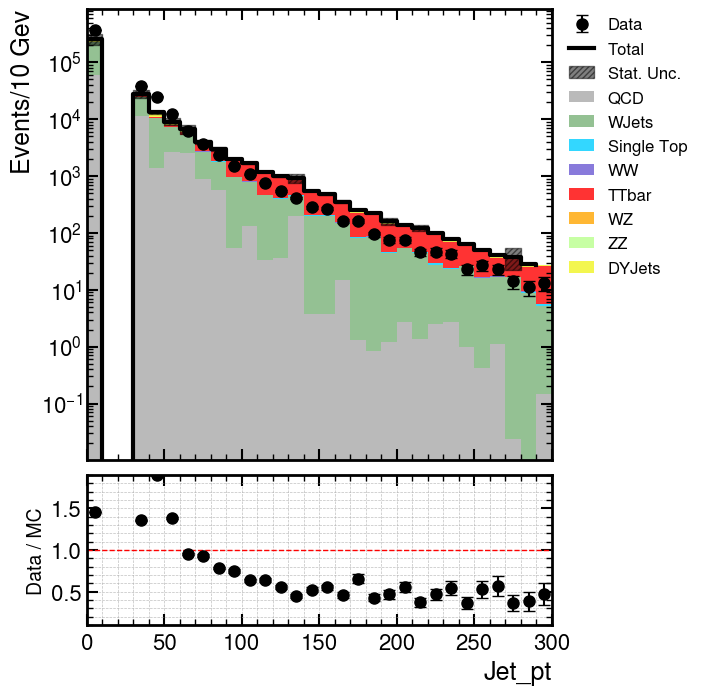

Data: 469312.0 ± 685.1 [entries: 469384]
MC  : 331212.4 ± 55460.9 [entries: 240601]
-----------------------------
QCD  79160.0 ± 55457.2  [entries: 142]
WJets  209522.3 ± 689.1  [entries: 109737]
Single Top  309.8 ± 4.4  [entries: 5684]
WW  229.3 ± 3.7  [entries: 4580]
TTbar  7803.0 ± 45.1  [entries: 36941]
WZ  69.7 ± 1.3  [entries: 3367]
ZZ  16.9 ± 0.4  [entries: 2421]
DYJets  34101.5 ± 145.5  [entries: 77729]
-----------------------------

### printing number of events for each bin and its estimated uncertainty ###

Data = ['375818.0', '0.0', '0.0', '37866.0', '24988.0', '12537.0', '6318.0', '3734.0', '2355.0', '1524.0', '1070.0', '768.0', '550.0', '411.0', '284.0', '266.0', '164.0', '165.0', '96.0', '75.0', '76.0', '46.0', '47.0', '43.0', '23.0', '27.0', '23.0', '14.0', '11.0', '13.0']
DataError = ['613.0', '0.0', '0.0', '194.6', '158.1', '112.0', '79.5', '61.1', '48.5', '39.0', '32.7', '27.7', '23.5', '20.3', '16.9', '16.3', '12.8', '12.8', '9.8', '8.7', '8.7', '6.8', '6.9', '6.6',

In [9]:
makePlot(dfs, var="Jet_pt", xmin=0, xmax=300, step_size=10, ylabel='Events/10 Gev', ylog=True, saveFig = False)

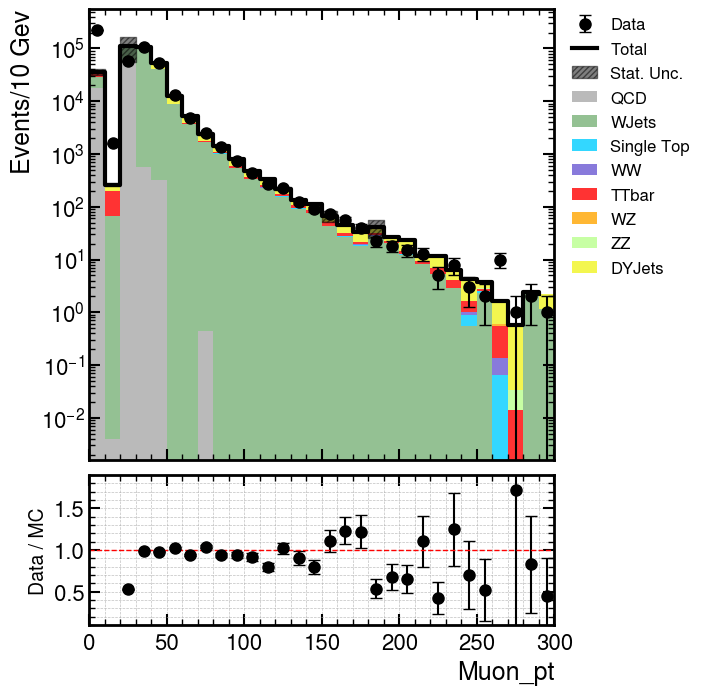

Data: 469375.0 ± 685.1 [entries: 469384]
MC  : 331398.8 ± 55459.3 [entries: 240601]
-----------------------------
QCD  79160.5 ± 55457.2  [entries: 142]
WJets  209572.0 ± 689.2  [entries: 109737]
Single Top  311.4 ± 4.4  [entries: 5684]
WW  229.9 ± 3.7  [entries: 4580]
TTbar  7928.0 ± 45.5  [entries: 36941]
WZ  69.9 ± 1.3  [entries: 3367]
ZZ  16.9 ± 0.4  [entries: 2421]
DYJets  34110.2 ± 145.5  [entries: 77729]
-----------------------------

### printing number of events for each bin and its estimated uncertainty ###

Data = ['227265.0', '1581.0', '58135.0', '106554.0', '51900.0', '13123.0', '4870.0', '2453.0', '1332.0', '743.0', '441.0', '269.0', '226.0', '123.0', '90.0', '74.0', '56.0', '40.0', '22.0', '18.0', '15.0', '13.0', '5.0', '8.0', '3.0', '2.0', '10.0', '1.0', '2.0', '1.0']
DataError = ['476.7', '39.8', '241.1', '326.4', '227.8', '114.6', '69.8', '49.5', '36.5', '27.3', '21.0', '16.4', '15.0', '11.1', '9.5', '8.6', '7.5', '6.3', '4.7', '4.2', '3.9', '3.6', '2.2', '2.8', '1.7'

In [10]:
makePlot(dfs,  var="Muon_pt", xmin=0, xmax=300, step_size=10, ylabel='Events/10 Gev', ylog=True, saveFig = False)

In [11]:
sel1_dfs = []
btag_threshold=0.05
for df in dfs:
    label = df.label 
    color = df.color

    print(f'Applying selection to {label}')

    selection = (
        (df["NJet"] >= 4) &
        (df["NMuon"] == 1) &
        (ak.sum(df["Jet_btag"] >= btag_threshold, axis=1) >=2)&
        (df["triggerIsoMu24"] == 1) 
        

    )

    df_selected = df[selection]
    df_selected.label = label
    df_selected.color = color

    if len(df_selected) > 0:
        sel1_dfs.append(df_selected)


Applying selection to Data
Applying selection to QCD
Applying selection to WJets
Applying selection to Single Top
Applying selection to WW
Applying selection to TTbar
Applying selection to WZ
Applying selection to ZZ
Applying selection to DYJets


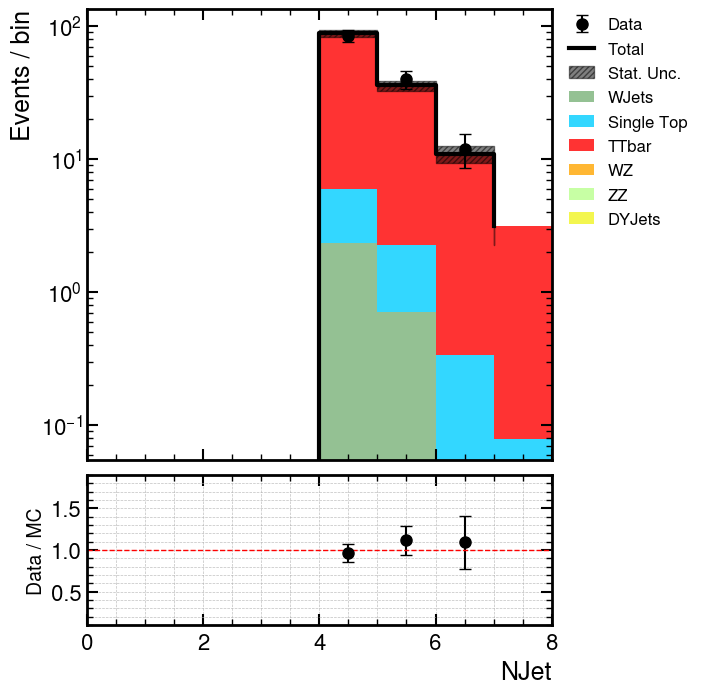

Data: 137.0 ± 11.7 [entries: 137]
MC  : 138.2 ± 6.4 [entries: 683]
-----------------------------
WJets  3.0 ± 2.4  [entries: 2]
Single Top  5.7 ± 0.6  [entries: 107]
TTbar  128.0 ± 5.8  [entries: 569]
WZ  0.0 ± 0.0  [entries: 1]
ZZ  0.0 ± 0.0  [entries: 1]
DYJets  1.5 ± 0.9  [entries: 3]
-----------------------------

### printing number of events for each bin and its estimated uncertainty ###

Data = ['0.0', '0.0', '0.0', '0.0', '85.0', '40.0', '12.0', '0.0']
DataError = ['0.0', '0.0', '0.0', '0.0', '9.2', '6.3', '3.5', '0.0']
MCTot = ['0.0', '0.0', '0.0', '0.0', '88.2', '35.9', '11.0', '3.2']
MCTotError = ['0.0', '0.0', '0.0', '0.0', '5.2', '3.1', '1.7', '0.9']

### detailed analysis of MC ###

WJets = ['0.0', '0.0', '0.0', '0.0', '2.3', '0.7', '0.0', '0.0']
WJetsError = ['0.0', '0.0', '0.0', '0.0', '2.3', '0.7', '0.0', '0.0']
Single Top = ['0.0', '0.0', '0.0', '0.0', '3.7', '1.5', '0.3', '0.1']
Single TopError = ['0.0', '0.0', '0.0', '0.0', '0.5', '0.3', '0.1', '0.1']
TTbar = ['0.0'

In [12]:
makePlot(sel1_dfs, var='NJet', xmin = 0, xmax = 8, ylog = True, saveFig = False)

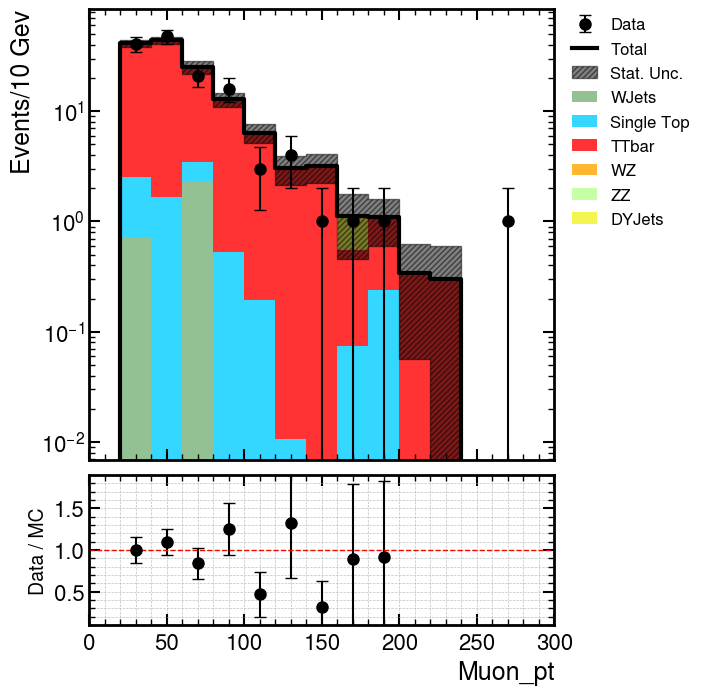

Data: 137.0 ± 11.7 [entries: 137]
MC  : 138.2 ± 6.4 [entries: 683]
-----------------------------
WJets  3.0 ± 2.4  [entries: 2]
Single Top  5.7 ± 0.6  [entries: 107]
TTbar  128.0 ± 5.8  [entries: 569]
WZ  0.0 ± 0.0  [entries: 1]
ZZ  0.0 ± 0.0  [entries: 1]
DYJets  1.5 ± 0.9  [entries: 3]
-----------------------------

### printing number of events for each bin and its estimated uncertainty ###

Data = ['0.0', '41.0', '48.0', '21.0', '16.0', '3.0', '4.0', '1.0', '1.0', '1.0', '0.0', '0.0', '0.0', '1.0', '0.0']
DataError = ['0.0', '6.4', '6.9', '4.6', '4.0', '1.7', '2.0', '1.0', '1.0', '1.0', '0.0', '0.0', '0.0', '1.0', '0.0']
MCTot = ['0.0', '41.2', '43.8', '24.9', '12.8', '6.4', '3.0', '3.2', '1.1', '1.1', '0.3', '0.3', '0.0', '0.0', '0.0']
MCTotError = ['0.0', '3.3', '3.3', '3.4', '1.8', '1.3', '0.9', '0.9', '0.7', '0.5', '0.3', '0.3', '0.0', '0.0', '0.0']

### detailed analysis of MC ###

WJets = ['0.0', '0.7', '0.0', '2.3', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.

In [13]:
makePlot(sel1_dfs, var="Muon_pt", xmin=0, xmax=300, step_size=20, ylabel='Events/10 Gev', ylog=True, saveFig = False)

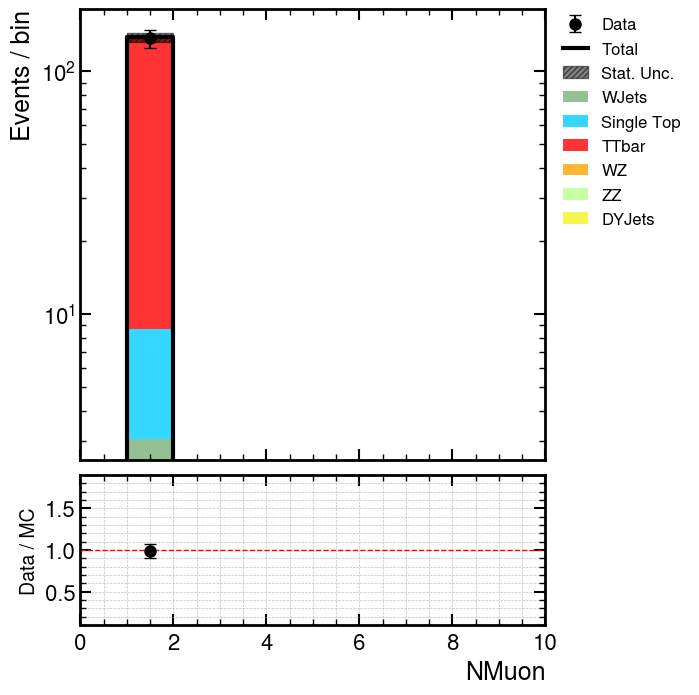

Data: 137.0 ± 11.7 [entries: 137]
MC  : 138.2 ± 6.4 [entries: 683]
-----------------------------
WJets  3.0 ± 2.4  [entries: 2]
Single Top  5.7 ± 0.6  [entries: 107]
TTbar  128.0 ± 5.8  [entries: 569]
WZ  0.0 ± 0.0  [entries: 1]
ZZ  0.0 ± 0.0  [entries: 1]
DYJets  1.5 ± 0.9  [entries: 3]
-----------------------------

### printing number of events for each bin and its estimated uncertainty ###

Data = ['0.0', '137.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']
DataError = ['0.0', '11.7', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']
MCTot = ['0.0', '138.2', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']
MCTotError = ['0.0', '6.4', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']

### detailed analysis of MC ###

WJets = ['0.0', '3.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']
WJetsError = ['0.0', '2.4', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']
Single Top = ['0.0', '5.7', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',

In [14]:
# plot muon multiplicity without any event selection
makePlot(sel1_dfs, var='NMuon', xmin = 0, xmax = 10, ylog = True, saveFig = False)

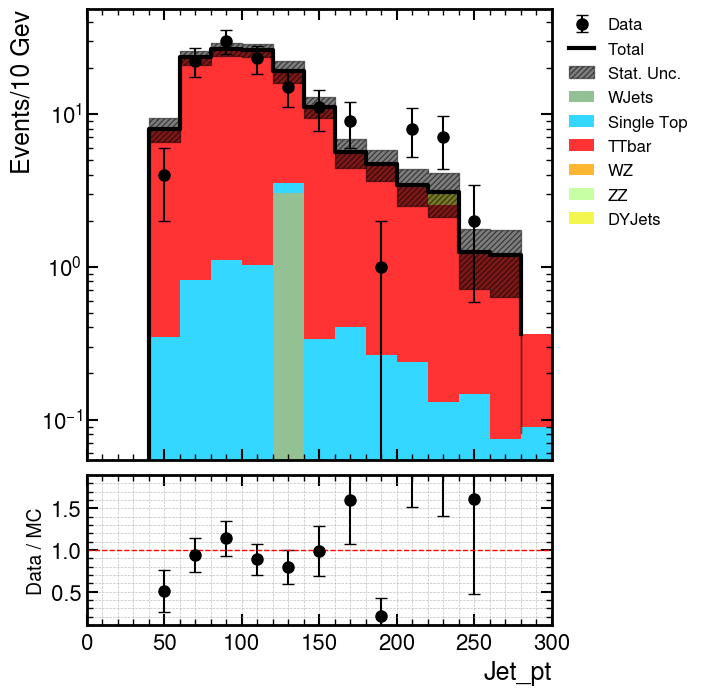

Data: 132.0 ± 11.5 [entries: 137]
MC  : 133.2 ± 6.3 [entries: 683]
-----------------------------
WJets  3.0 ± 2.4  [entries: 2]
Single Top  5.5 ± 0.6  [entries: 107]
TTbar  123.2 ± 5.7  [entries: 569]
WZ  0.0 ± 0.0  [entries: 1]
ZZ  0.0 ± 0.0  [entries: 1]
DYJets  1.5 ± 0.9  [entries: 3]
-----------------------------

### printing number of events for each bin and its estimated uncertainty ###

Data = ['0.0', '0.0', '4.0', '22.0', '30.0', '23.0', '15.0', '11.0', '9.0', '1.0', '8.0', '7.0', '2.0', '0.0', '0.0']
DataError = ['0.0', '0.0', '2.0', '4.7', '5.5', '4.8', '3.9', '3.3', '3.0', '1.0', '2.8', '2.6', '1.4', '0.0', '0.0']
MCTot = ['0.0', '0.0', '7.9', '23.3', '26.4', '25.9', '18.9', '11.1', '5.6', '4.7', '3.4', '3.1', '1.2', '1.2', '0.4']
MCTotError = ['0.0', '0.0', '1.4', '2.4', '2.6', '2.6', '3.2', '1.7', '1.2', '1.1', '0.9', '1.0', '0.5', '0.6', '0.3']

### detailed analysis of MC ###

WJets = ['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '3.0', '0.0', '0.0', '0.0', '0.0', '0.0', '

In [15]:

    
makePlot(sel1_dfs, var="Jet_pt", xmin=0, xmax=300, step_size=20, ylabel='Events/10 Gev', ylog=True, saveFig = False)

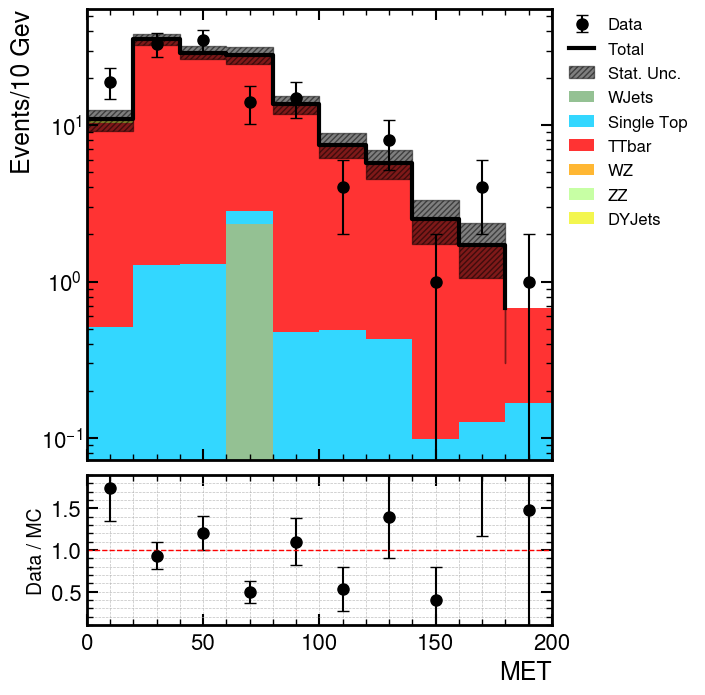

Data: 134.0 ± 11.6 [entries: 137]
MC  : 135.3 ± 6.3 [entries: 683]
-----------------------------
WJets  2.3 ± 2.3  [entries: 2]
Single Top  5.4 ± 0.6  [entries: 107]
TTbar  126.1 ± 5.8  [entries: 569]
WZ  0.0 ± 0.0  [entries: 1]
ZZ  0.0 ± 0.0  [entries: 1]
DYJets  1.5 ± 0.9  [entries: 3]
-----------------------------

### printing number of events for each bin and its estimated uncertainty ###

Data = ['19.0', '33.0', '35.0', '14.0', '15.0', '4.0', '8.0', '1.0', '4.0', '1.0']
DataError = ['4.4', '5.7', '5.9', '3.7', '3.9', '2.0', '2.8', '1.0', '2.0', '1.0']
MCTot = ['10.9', '35.4', '29.2', '28.0', '13.6', '7.5', '5.7', '2.5', '1.7', '0.7']
MCTotError = ['1.7', '3.0', '2.7', '3.5', '1.9', '1.4', '1.2', '0.8', '0.7', '0.4']

### detailed analysis of MC ###

WJets = ['0.0', '0.0', '0.0', '2.3', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']
WJetsError = ['0.0', '0.0', '0.0', '2.3', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']
Single Top = ['0.5', '1.3', '1.3', '0.5', '0.5', '0.5', '0.4', '0.1', '

In [16]:
makePlot(sel1_dfs, var="MET", xmin=0, xmax=200, step_size=20, ylabel='Events/10 Gev', ylog = True, saveFig = False)

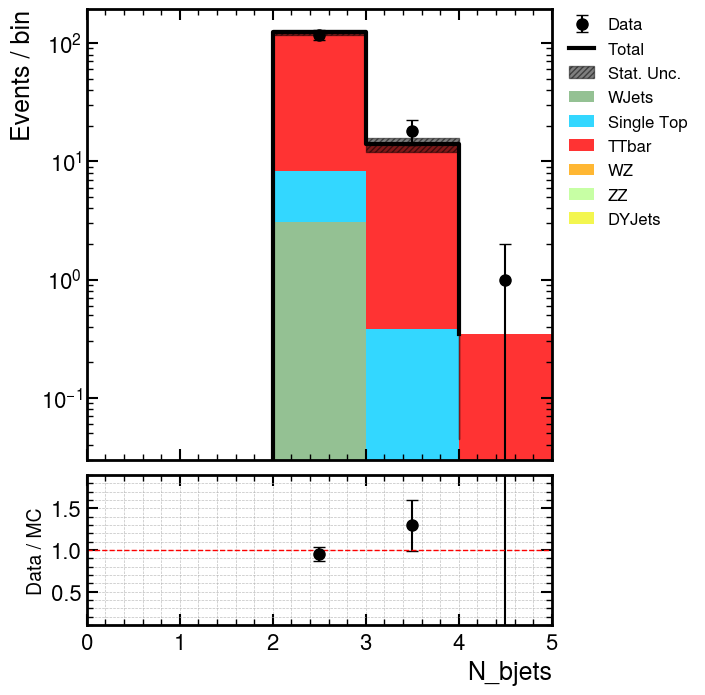

Data: 137.0 ± 11.7 [entries: 137]
MC  : 138.2 ± 6.4 [entries: 683]
-----------------------------
WJets  3.0 ± 2.4  [entries: 2]
Single Top  5.7 ± 0.6  [entries: 107]
TTbar  128.0 ± 5.8  [entries: 569]
WZ  0.0 ± 0.0  [entries: 1]
ZZ  0.0 ± 0.0  [entries: 1]
DYJets  1.5 ± 0.9  [entries: 3]
-----------------------------

### printing number of events for each bin and its estimated uncertainty ###

Data = ['0.0', '0.0', '118.0', '18.0', '1.0']
DataError = ['0.0', '0.0', '10.9', '4.2', '1.0']
MCTot = ['0.0', '0.0', '123.9', '13.9', '0.3']
MCTotError = ['0.0', '0.0', '6.1', '1.9', '0.3']

### detailed analysis of MC ###

WJets = ['0.0', '0.0', '3.0', '0.0', '0.0']
WJetsError = ['0.0', '0.0', '2.4', '0.0', '0.0']
Single Top = ['0.0', '0.0', '5.3', '0.4', '0.0']
Single TopError = ['0.0', '0.0', '0.6', '0.1', '0.0']
TTbar = ['0.0', '0.0', '114.1', '13.5', '0.3']
TTbarError = ['0.0', '0.0', '5.5', '1.9', '0.3']
WZ = ['0.0', '0.0', '0.0', '0.0', '0.0']
WZError = ['0.0', '0.0', '0.0', '0.0', '0.0'

In [17]:
makePlot(sel1_dfs, var='N_bjets', xmin = 0, xmax = 5,  ylog = True, saveFig = False)

In [18]:
for df in dfs:
    # Pad the Jet_Pt array to ensure at least one element, using None for padding
    padded_muon_px = ak.pad_none(df['Muon_Iso'], 1, clip=True)
    # Fill None values with 0
    df['Muon_Iso'] = ak.fill_none(padded_muon_px, 0)

In [19]:
# Assume df_ttbar = dfs[5] corresponds to TTbar sample
df_ttbar = dfs[5]

In [20]:
df_ttbar

<Array [{NJet: 3, Jet_Px: [14.5, ... 0]}] type='36941 * {"NJet": int32, "Jet_Px"...'>

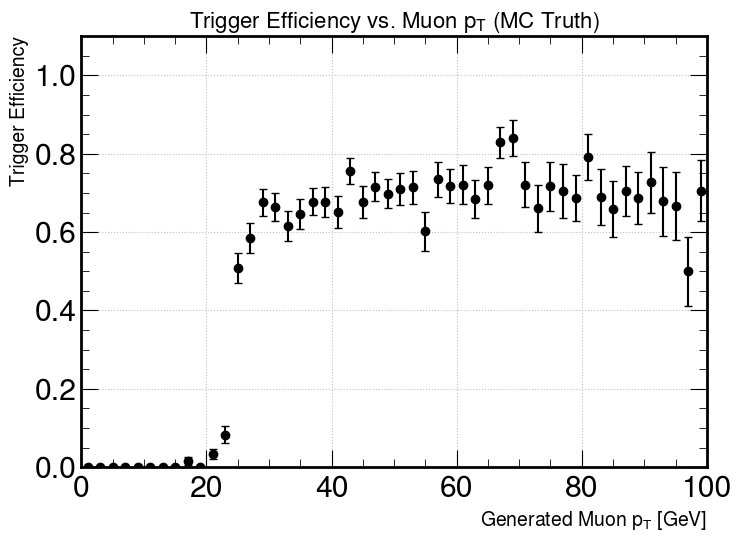

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Extract provided arrays
mc_muon_mask = np.abs(df_ttbar["MCleptonPDGid"]) == 13
gen_muon_pt = np.sqrt(df_ttbar["MClepton_px"]**2 + df_ttbar["MClepton_py"]**2)
gen_muon_pt = gen_muon_pt[mc_muon_mask]
trigger_pass = df_ttbar["triggerIsoMu24"][mc_muon_mask] == 1

# Define binning for pt range from 0 to 100 GeV
bins = np.arange(0, 100.1, 2)  # 1 GeV bins
bin_centers = (bins[:-1] + bins[1:]) / 2

efficiencies = []
errors = []

# Calculate trigger efficiency and statistical uncertainty
for i in range(len(bins) - 1):
    in_bin = (gen_muon_pt >= bins[i]) & (gen_muon_pt < bins[i + 1])
    n_total = np.sum(in_bin)
    n_pass = np.sum(trigger_pass[in_bin])
    
    if n_total > 0:
        eff = n_pass / n_total
        err = math.sqrt(eff * (1 - eff) / n_total)
    else:
        eff, err = 0, 0

    efficiencies.append(eff)
    errors.append(err)

# Plot trigger efficiency vs. generated muon pt
plt.figure(figsize=(8, 6))
plt.errorbar(bin_centers, efficiencies, yerr=errors, fmt='o', capsize=3, color='black')
plt.xlabel("Generated Muon $p_T$ [GeV]", fontsize=14)
plt.ylabel("Trigger Efficiency", fontsize=14)
plt.title("Trigger Efficiency vs. Muon $p_T$ (MC Truth)", fontsize=16)
plt.grid(True)
plt.ylim(0, 1.1)
plt.xlim(0, 100)
plt.tight_layout()
plt.show()


In [22]:
import numpy as np
import math

# Compute reconstructed muon pT
#reco_muon_pt = np.sqrt(df_ttbar["Muon_Px"][:, 0]**2 + df_ttbar["Muon_Py"][:, 0]**2)

# Event weights
weights = df_ttbar["EventWeight"]
selected= ((df_ttbar["triggerIsoMu24"] == 1)& df_ttbar["NMuon"]==1)

# Weighted counts
N_gen = np.sum(weights)                    # total weighted events
N_sel = np.sum(weights[selected])          # selected weighted events

# Efficiency
eff_trigger = N_sel / N_gen if N_gen > 0 else 0

# Statistical error using binomial propagation
err_trigger = np.sqrt(eff_trigger * (1 - eff_trigger) / N_gen) if N_gen > 0 else 0

print(f"Trigger efficiency: {eff_trigger:.4f} ± {err_trigger:.4f}")

Trigger efficiency: 0.1103 ± 0.0035


In [23]:
# Acceptance ε_acc: number of events passing full selection over total generated
# Assume total generated events = len(df_ttbar)
btag_threshold=0

sel_mask = (
    (df_ttbar["NJet"] >= 4) &
    (df_ttbar["NMuon"] == 1) &
    (ak.sum(df_ttbar["Jet_btag"] >= btag_threshold, axis=1) >=2)

)
 
n_sel_ttbar= np.sum(weights[sel_mask])  
eff_acceptance = n_sel_ttbar / N_gen

# Calculate statistical uncertainty using binomial error formula
acceptance_error = np.sqrt(eff_acceptance * (1 - eff_acceptance) / N_gen)

eff_acceptance, acceptance_error


(0.023558954, 0.0017032515019460136)

In [24]:
n_sel_ttbar

186.81015

In [25]:
number_total


NameError: name 'number_total' is not defined

In [26]:
import numpy as np

# Updated background sum using event weights
N_bkg = 0
bg_yields = []

for i in range(1, len(dfs)):
    if i == 5:  # skip ttbar (signal)
        continue
    df_bg = dfs[i]
    bg_mask = (
        (df_bg["NJet"] >= 4) &
        (df_bg["NMuon"] == 1) &
        (ak.sum(df_bg["Jet_btag"] >= btag_threshold, axis=1) >=2) &
        (df_bg["triggerIsoMu24"] == 1)
    )
    yield_sum = np.sum(df_bg["EventWeight"][bg_mask])
    N_bkg += yield_sum
    bg_yields.append((df_bg.label, yield_sum))

N_bkg, bg_yields


(10.21750520169735,
 [('QCD', 0.0),
  ('WJets', 3.044544),
  ('Single Top', 5.654461),
  ('WW', 0.0),
  ('WZ', 0.024022492),
  ('ZZ', 0.00801344),
  ('DYJets', 1.4864644)])

In [27]:
bg_mask

<Array [False, False, False, ... False, False] type='77729 * bool'>

In [28]:
eta_cut

NameError: name 'eta_cut' is not defined

In [29]:
# Data observed
df_data = dfs[0]
obs_mask = (
    (df_data["NJet"] >= 4) &
    (df_data["NMuon"] == 1) &
    (ak.sum(df_data["Jet_btag"] >= btag_threshold, axis=1) >=2)&
    (df_data["triggerIsoMu24"] == 1) 
)
N_obs = np.sum(obs_mask)
N_obs

137

/depot/cms/kernels/python3/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


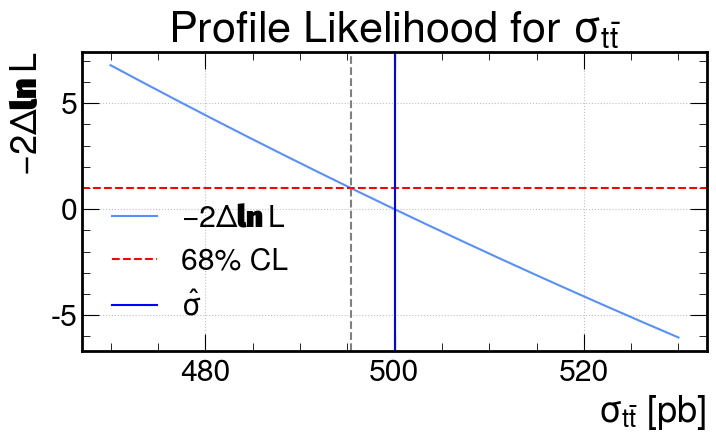

(499.9999865167874,
 array(495.36305034),
 array(nan),
 0.002597444,
 0.0002052579865214199)

In [30]:
# Use realistic values from the user-provided data analysis

L_pb = 50  # Integrated luminosity in pb^-1


# Combined total efficiency (Aε)
A_eps = eff_trigger * eff_acceptance
A_eps_error = A_eps * np.sqrt((err_trigger / eff_trigger)**2 + (acceptance_error / eff_acceptance)**2)

# Profile likelihood for cross section σ
from scipy.stats import poisson
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt

# Negative log-likelihood function
def neg_log_likelihood(sigma, N_obs, N_bkg, L, A_eps):
    mu = N_bkg + sigma * L * A_eps
    return -poisson.logpmf(N_obs, mu)

# MLE for σ
result = minimize_scalar(neg_log_likelihood, bounds=(0, 500), method='bounded',
                         args=(N_obs, N_bkg, L_pb, A_eps))
sigma_hat = result.x
nll_min = result.fun

# Likelihood scan to extract 68% confidence interval
sigmas = np.linspace(max(1e-3, sigma_hat - 30), sigma_hat + 30, 500)
nll_vals = [neg_log_likelihood(s, N_obs, N_bkg, L_pb, A_eps) for s in sigmas]
delta_nll = [2 * (nll - nll_min) for nll in nll_vals]

from scipy.interpolate import interp1d
left = interp1d(delta_nll[:np.argmin(delta_nll)], sigmas[:np.argmin(delta_nll)], fill_value='extrapolate')
right = interp1d(delta_nll[np.argmin(delta_nll):], sigmas[np.argmin(delta_nll):], fill_value='extrapolate')
sigma_lower = left(1)
sigma_upper = right(1)

# Plot likelihood curve
plt.figure(figsize=(8, 5))
plt.plot(sigmas, delta_nll, label=r'$-2\Delta \ln \mathcal{L}$')
plt.axhline(1, color='red', linestyle='--', label='68% CL')
plt.axvline(sigma_lower, color='gray', linestyle='--')
plt.axvline(sigma_upper, color='gray', linestyle='--')
plt.axvline(sigma_hat, color='blue', linestyle='-', label=r'$\hat{\sigma}$')
plt.xlabel(r'$\sigma_{t\bar{t}}$ [pb]')
plt.ylabel(r'$-2\Delta \ln \mathcal{L}$')
plt.title('Profile Likelihood for $\\sigma_{t\\bar{t}}$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

sigma_hat, sigma_lower, sigma_upper, A_eps, A_eps_error


In [31]:
# Step 1: Purity and its error
luminosity=50
purity = (N_obs - N_bkg) / N_obs
delta_purity = math.sqrt((N_bkg / N_obs**2)**2 * N_obs + (1 / N_obs)**2 * N_bkg)  # simplified, conservatively

# Step 2: Signal yield
N_signal = N_obs * purity

# Step 3: Cross-section formula
sigma_ttbar = N_signal / (eff_trigger * eff_acceptance * luminosity)

# Step 4: Uncertainty propagation
# dσ/σ = sqrt( (dN/N)^2 + (dε_trig/ε_trig)^2 + (dε_acc/ε_acc)^2 )
delta_N = math.sqrt(N_obs)  # statistical uncertainty on observed count
rel_uncert_N = delta_N / N_signal
rel_uncert_trig = err_trigger / eff_trigger
rel_uncert_acc = acceptance_error / eff_acceptance

relative_uncertainty = math.sqrt(rel_uncert_N**2 + rel_uncert_trig**2 + rel_uncert_acc**2)
delta_sigma_ttbar = sigma_ttbar * relative_uncertainty

(sigma_ttbar, delta_sigma_ttbar)

(976.2096520695662, 118.63189187542778)

In [107]:
N_signal

272.0341942757368

In [108]:
eff_trigger

0.12633936

In [109]:
eff_acceptance

0.048156098

In [46]:
luminosity

50

In [35]:
df_data=dfs[0]
df_QCD=dfs[1]
df_WJets=dfs[2]
df_ST=dfs[3]
df_WW=dfs[4]
df_ttbar=dfs[5]
df_WZ=dfs[6]
df_ZZ=dfs[7]
df_DYJ=dfs[8]

In [71]:
def compute_mjjj(df, label="sample", return_weights=False):
    # Compute MET
    met = np.sqrt(df["MET_px"]**2 + df["MET_py"]**2)
    sel_mask = (
        (df["NMuon"] == 1) &
        (df["NJet"] >= 4) &
        (ak.sum(df["Jet_btag"] >= 0.679, axis=1) >= 1) &
        (met > 20)&
        (df["triggerIsoMu24"] == 1)
    )
    df_sel = df[sel_mask]
    jets = {
        "px": df_sel["Jet_Px"],
        "py": df_sel["Jet_Py"],
        "pz": df_sel["Jet_Pz"],
        "E":  df_sel["Jet_E"],
        "btag": df_sel["Jet_btag"]
    }

    weights = df_sel["EventWeight"] if "EventWeight" in df_sel.fields else None
    mjjj_vals, mjjj_weights = [], []

    for i in range(len(df_sel)):
        px, py, pz, E, btag = jets["px"][i], jets["py"][i], jets["pz"][i], jets["E"][i], jets["btag"][i]
        w = weights[i] if weights is not None else 1.0
        njets = len(px)
        if njets < 4: continue

        bjets = [j for j in range(njets) if btag[j] > 0]
        ljets = [j for j in range(njets) if btag[j] <= 0]

        candidates = []
        for i1, i2 in combinations(ljets, 2):
            mjj = invariant_mass(px[i1]+px[i2], py[i1]+py[i2], pz[i1]+pz[i2], E[i1]+E[i2])
            if abs(mjj - 80.4) > 15: continue
            for b in bjets:
                if b in [i1, i2]: continue
                m_jjj = invariant_mass(
                    px[i1] + px[i2] + px[b],
                    py[i1] + py[i2] + py[b],
                    pz[i1] + pz[i2] + pz[b],
                    E[i1]  + E[i2]  + E[b]
                )
                candidates.append(m_jjj)

        if candidates:
            best = sorted(candidates, key=lambda x: abs(x - 172))[0]
            mjjj_vals.append(best)
            mjjj_weights.append(w)

    print(f"{label}: selected {len(mjjj_vals)} events")
    if return_weights:
        return np.array(mjjj_vals), np.array(mjjj_weights)
    else:
        return np.array(mjjj_vals)


In [72]:
# Data (no weights)
mjjj_data = compute_mjjj(df_data, label="Data")

# MC with weights
mjjj_ttbar, w_ttbar = compute_mjjj(df_ttbar, label="TTbar", return_weights=True)
mjjj_wjets, w_wjets = compute_mjjj(df_WJets, label="WJets", return_weights=True)
mjjj_dyj,   w_dyj   = compute_mjjj(df_DYJ,   label="DYJets", return_weights=True)
mjjj_ww,    w_ww    = compute_mjjj(df_WW,    label="WW", return_weights=True)
mjjj_wz,    w_wz    = compute_mjjj(df_WZ,    label="WZ", return_weights=True)
mjjj_zz,    w_zz    = compute_mjjj(df_ZZ,    label="ZZ", return_weights=True)
mjjj_st,    w_st    = compute_mjjj(df_ST,    label="Single Top", return_weights=True)
mjjj_qcd,   w_qcd   = compute_mjjj(df_QCD,   label="QCD", return_weights=True)


Data: selected 166 events
TTbar: selected 648 events
WJets: selected 5 events
DYJets: selected 5 events
WW: selected 1 events
WZ: selected 3 events
ZZ: selected 0 events
Single Top: selected 132 events
QCD: selected 0 events


In [84]:
import numpy as np

# CMS-style binning
xmin, xmax = 100, 300
nbins = 40
bin_edges = np.linspace(xmin, xmax, nbins + 1)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
# Data histogram
h_data, _ = np.histogram(mjjj_data, bins=bin_edges)
h_data_err = np.sqrt(h_data)

# MC histograms (with weights)
h_ttbar, _ = np.histogram(mjjj_ttbar, bins=bin_edges, weights=w_ttbar)
h_ttbar_err = np.sqrt(np.histogram(mjjj_ttbar, bins=bin_edges, weights=w_ttbar**2)[0])

h_wjets, _ = np.histogram(mjjj_wjets, bins=bin_edges, weights=w_wjets)
h_wjets_err = np.sqrt(np.histogram(mjjj_wjets, bins=bin_edges, weights=w_wjets**2)[0])

h_dyj, _ = np.histogram(mjjj_dyj, bins=bin_edges, weights=w_dyj)
h_dyj_err = np.sqrt(np.histogram(mjjj_dyj, bins=bin_edges, weights=w_dyj**2)[0])

h_ww, _ = np.histogram(mjjj_ww, bins=bin_edges, weights=w_ww)
h_ww_err = np.sqrt(np.histogram(mjjj_ww, bins=bin_edges, weights=w_ww**2)[0])

h_wz, _ = np.histogram(mjjj_wz, bins=bin_edges, weights=w_wz)
h_wz_err = np.sqrt(np.histogram(mjjj_wz, bins=bin_edges, weights=w_wz**2)[0])

h_zz, _ = np.histogram(mjjj_zz, bins=bin_edges, weights=w_zz)
h_zz_err = np.sqrt(np.histogram(mjjj_zz, bins=bin_edges, weights=w_zz**2)[0])

h_st, _ = np.histogram(mjjj_st, bins=bin_edges, weights=w_st)
h_st_err = np.sqrt(np.histogram(mjjj_st, bins=bin_edges, weights=w_st**2)[0])

h_qcd, _ = np.histogram(mjjj_qcd, bins=bin_edges, weights=w_qcd)
h_qcd_err = np.sqrt(np.histogram(mjjj_qcd, bins=bin_edges, weights=w_qcd**2)[0])

mc_histograms = {
    'TTbar':      (h_ttbar, h_ttbar_err, '#ff0000'),
    'WJets':      (h_wjets, h_wjets_err, '#79b278'),
    'DYJets':     (h_dyj,   h_dyj_err,   '#f0f423'),
    'WW':         (h_ww,    h_ww_err,    '#6b59d3'),
    'WZ':         (h_wz,    h_wz_err,    'orange'),
    'ZZ':         (h_zz,    h_zz_err,    '#baff8d'),
    'Single Top': (h_st,    h_st_err,    '#00cdff'),
    'QCD':        (h_qcd,   h_qcd_err,   '#a9a9a9')
}


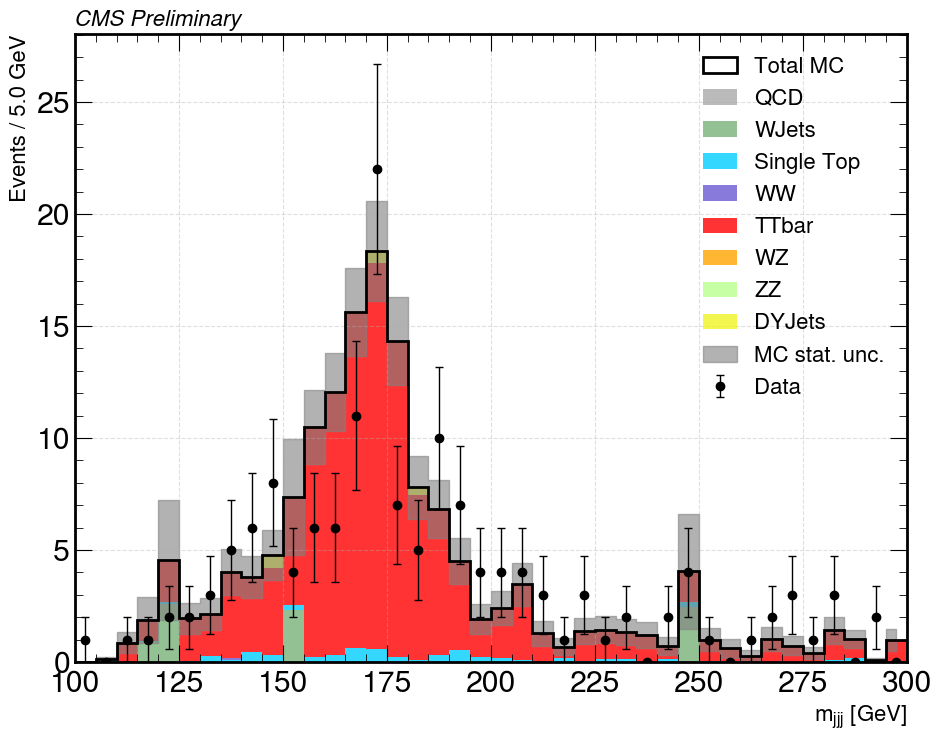

In [86]:
import matplotlib.pyplot as plt
import numpy as np

# Plot settings
plt.figure(figsize=(10, 8))
bin_width = bin_edges[1] - bin_edges[0]

# Stack backgrounds (order matters for correct stacking)
bkg_order = ['QCD', 'WJets', 'Single Top', 'WW', 'TTbar', 'WZ', 'ZZ', 'DYJets']
stack_vals = []
stack_errs = []
colors = []
labels = []

for key in bkg_order:
    hist, err, color = mc_histograms[key]
    stack_vals.append(hist)
    stack_errs.append(err)
    colors.append(color)
    labels.append(key)

# Compute total MC and total error
total_mc = np.sum(stack_vals, axis=0)
total_mc_err = np.sqrt(np.sum(np.square(stack_errs), axis=0))

# Plot stacked histogram outline (step)
_, bins, _ = plt.hist(
    bin_centers,
    bins=bin_edges,
    weights=total_mc,
    histtype='step',
    color='black',
    linewidth=2,
    label='Total MC'
)

# Stacked background fill
plt.hist(
    [bin_centers]*len(stack_vals),
    bins=bin_edges,
    weights=stack_vals,
    stacked=True,
    color=colors,
    label=labels,
    alpha=0.8
)

# MC statistical uncertainty band
plt.fill_between(
    bin_centers,
    total_mc - total_mc_err,
    total_mc + total_mc_err,
    step='mid',
    color='gray',
    alpha=0.6,
    label='MC stat. unc.'
)

# Data points
plt.errorbar(
    bin_centers, h_data,
    yerr=h_data_err,
    fmt='o', color='black', label='Data',
    capsize=3, markersize=6, linewidth=1
)

# Labels and CMS-style formatting
plt.xlabel(r"$m_{jjj}$ [GeV]", fontsize=16)
plt.ylabel("Events / %.1f GeV" % bin_width, fontsize=16)
plt.title("CMS Preliminary", loc='left', fontsize=16, style='italic')
plt.legend(fontsize=16, loc='upper right', bbox_to_anchor=(1.0, 1.0))
plt.grid(True, linestyle="--", alpha=0.4)
plt.xlim(xmin, xmax)
plt.tight_layout()
plt.show()


In [253]:
import numpy as np
import matplotlib.pyplot as plt
import math
import awkward as ak

# Apply event selection
selection = (
    (df_ttbar["NJet"] >= 3) &
    (df_ttbar["NMuon"] >= 1) &
    (ak.sum(df_ttbar["Jet_btag"] >= btag_threshold, axis=1) >=1)&
    (df_ttbar["triggerIsoMu24"] == 1)
)
df_ttbar_sel = df_ttbar[selection]

# Generator-level top quark mass reconstruction
lep_px = df_ttbar_sel["MClepton_px"]
lep_py = df_ttbar_sel["MClepton_py"]
lep_pz = df_ttbar_sel["MClepton_pz"]
lep_e = np.sqrt(lep_px**2 + lep_py**2 + lep_pz**2)

nu_px = df_ttbar_sel["MCneutrino_px"]
nu_py = df_ttbar_sel["MCneutrino_py"]
nu_pz = df_ttbar_sel["MCneutrino_pz"]
nu_e = np.sqrt(nu_px**2 + nu_py**2 + nu_pz**2)

b_px = df_ttbar_sel["MCleptonicBottom_px"]
b_py = df_ttbar_sel["MCleptonicBottom_py"]
b_pz = df_ttbar_sel["MCleptonicBottom_pz"]
b_e = np.sqrt(b_px**2 + b_py**2 + b_pz**2 + (4.8**2))

top_px = lep_px + nu_px + b_px
top_py = lep_py + nu_py + b_py
top_pz = lep_pz + nu_pz + b_pz
top_e = lep_e + nu_e + b_e
top_mass_gen = np.sqrt(top_e**2 - top_px**2 - top_py**2 - top_pz**2)

top_mass_gen

<Array [173, 4.8, 4.8, 4.8, ... 173, 173, 173] type='1169 * float32'>

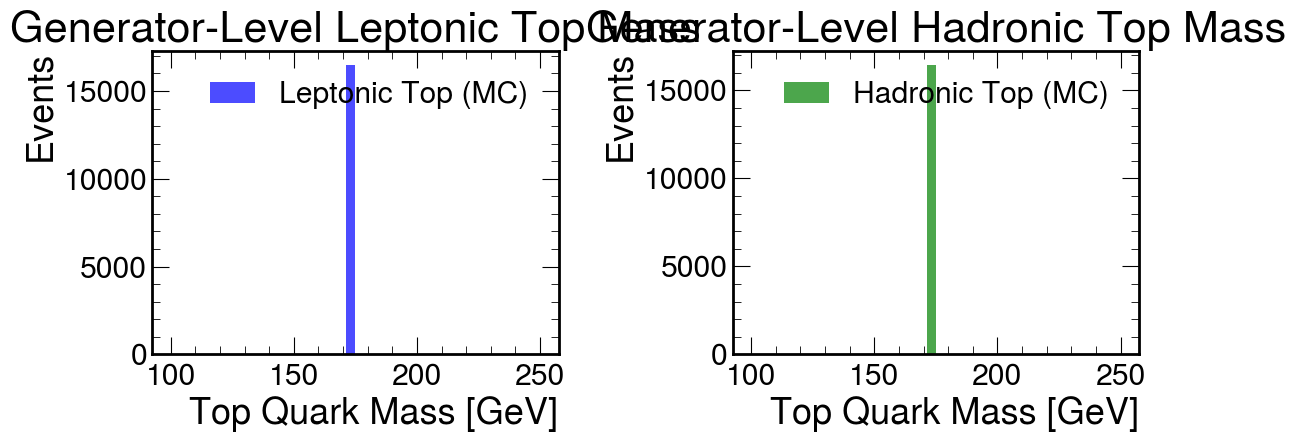

In [254]:
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt

# Use the full ttbar MC sample (no selection)
df_ttbar = dfs[5]  # Assuming this is the ttbar sample

# --- Generator-Level Leptonic Top Reconstruction (μ + ν + b) ---
lep_px = df_ttbar["MClepton_px"]
lep_py = df_ttbar["MClepton_py"]
lep_pz = df_ttbar["MClepton_pz"]
lep_e  = np.sqrt(lep_px**2 + lep_py**2 + lep_pz**2)  # massless lepton

nu_px = df_ttbar["MCneutrino_px"]
nu_py = df_ttbar["MCneutrino_py"]
nu_pz = df_ttbar["MCneutrino_pz"]
nu_e  = np.sqrt(nu_px**2 + nu_py**2 + nu_pz**2)  # massless neutrino

blep_px = df_ttbar["MCleptonicBottom_px"]
blep_py = df_ttbar["MCleptonicBottom_py"]
blep_pz = df_ttbar["MCleptonicBottom_pz"]
blep_e  = np.sqrt(blep_px**2 + blep_py**2 + blep_pz**2 + 4.8**2)  # b-quark mass ~4.8 GeV

lep_top_px = lep_px + nu_px + blep_px
lep_top_py = lep_py + nu_py + blep_py
lep_top_pz = lep_pz + nu_pz + blep_pz
lep_top_e  = lep_e + nu_e + blep_e

lep_top_mass = np.sqrt(lep_top_e**2 - lep_top_px**2 - lep_top_py**2 - lep_top_pz**2)

# --- Generator-Level Hadronic Top Reconstruction (W + b) ---
q1_px = df_ttbar["MChadronicWDecayQuark_px"]
q1_py = df_ttbar["MChadronicWDecayQuark_py"]
q1_pz = df_ttbar["MChadronicWDecayQuark_pz"]
q1_e  = np.sqrt(q1_px**2 + q1_py**2 + q1_pz**2)

q2_px = df_ttbar["MChadronicWDecayQuarkBar_px"]
q2_py = df_ttbar["MChadronicWDecayQuarkBar_py"]
q2_pz = df_ttbar["MChadronicWDecayQuarkBar_pz"]
q2_e  = np.sqrt(q2_px**2 + q2_py**2 + q2_pz**2)

bhad_px = df_ttbar["MChadronicBottom_px"]
bhad_py = df_ttbar["MChadronicBottom_py"]
bhad_pz = df_ttbar["MChadronicBottom_pz"]
bhad_e  = np.sqrt(bhad_px**2 + bhad_py**2 + bhad_pz**2 + 4.8**2)

had_top_px = q1_px + q2_px + bhad_px
had_top_py = q1_py + q2_py + bhad_py
had_top_pz = q1_pz + q2_pz + bhad_pz
had_top_e  = q1_e + q2_e + bhad_e

had_top_mass = np.sqrt(had_top_e**2 - had_top_px**2 - had_top_py**2 - had_top_pz**2)

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(ak.to_numpy(lep_top_mass), bins=40, range=(100, 250), color='blue', alpha=0.7, label='Leptonic Top (MC)')
plt.xlabel('Top Quark Mass [GeV]')
plt.ylabel('Events')
plt.title('Generator-Level Leptonic Top Mass')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(ak.to_numpy(had_top_mass), bins=40, range=(100, 250), color='green', alpha=0.7, label='Hadronic Top (MC)')
plt.xlabel('Top Quark Mass [GeV]')
plt.ylabel('Events')
plt.title('Generator-Level Hadronic Top Mass')
plt.legend()

plt.tight_layout()
plt.show()


In [41]:
df_ttbar = dfs[5] 
jets_px = ak.to_list(df_ttbar["Jet_Px"])
jets_py = ak.to_list(df_ttbar["Jet_Py"])
jets_pz = ak.to_list(df_ttbar["Jet_Pz"])
jets_e  = ak.to_list(df_ttbar["Jet_E"])
jets_btag = ak.to_list(df_ttbar["Jet_btag"])  # shape should now be 996 * Njets


In [72]:
jets_btag

[[2.046097993850708, 2.287385940551758, -1.0],
 [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0],
 [-1.0, -1.0, 1.7072395086288452, -1.0],
 [3.630891799926758, 3.0245561599731445],
 [-1.0, -1.0, 3.7499330043792725],
 [-1.0, -1.0, 2.2877495288848877, -1.0, 2.9008631706237793],
 [2.6792263984680176, -1.0, -1.0, -1.0],
 [2.4239814281463623, -1.0, -1.0],
 [-1.0, 2.7583775520324707, -1.0, -1.0, -1.0, -1.0, -1.0],
 [-1.0, 3.194457530975342, 1.403603196144104],
 [-1.0, 3.405219554901123, -1.0, -1.0, -1.0],
 [2.3892993927001953, -1.0, -1.0, 2.235335111618042, -1.0],
 [2.845724582672119, -1.0, -1.0],
 [3.302395820617676],
 [2.9362847805023193, 1.8659189939498901, -1.0, -1.0],
 [3.1457111835479736, 2.897934913635254, 2.800997018814087, -1.0, -1.0],
 [-1.0, 3.203273057937622, -1.0, -1.0, -1.0],
 [-1.0, 2.2311713695526123, -1.0, -1.0],
 [1.7250744104385376, -1.0],
 [-1.0, -1.0, 3.5761375427246094],
 [-1.0, -1.0, -1.0],
 [-1.0, -1.0, -1.0, -1.0, -1.0],
 [3.8820314407348633, 3.21398663520813, -1.0],
 [-1.0, 2.6

In [69]:
(ak.sum(df.Jet_btag >= 1, axis=1)) 

<Array [0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='77729 * int64'>

In [71]:
num_btagged = ak.sum(df.Jet_btag >= 1, axis=1)
print("Example b-tag counts:", num_btagged[:100])


Example b-tag counts: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [67]:
# Apply event selection
selection = (
    (df_ttbar["NJet"] >= 3) &
    (df_ttbar["NMuon"] >= 1) &
    (ak.sum(df_ttbar["Jet_btag"] >= 1, axis=1) >= 1)  &
    (df_ttbar["Muon_pt"] > 25) &
    (df_ttbar["triggerIsoMu24"] == 1)
    #(df_ttbar["Muon_Iso"][:, 0] < 0.15)
)
df_ttbar_sel = df_ttbar[selection]

In [68]:
df_ttbar_sel

<Array [{NJet: 3, Jet_Px: [, ... MET: 9.47}] type='2272 * {"NJet": int32, "Jet_P...'>

In [66]:
df_ttbar

<Array [{NJet: 3, Jet_Px: [, ... MET: 40.4}] type='36941 * {"NJet": int32, "Jet_...'>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak

# Select from already filtered df_ttbar_sel (assuming selection already applied)
df = df_ttbar_sel

jets_px = ak.to_list(df_ttbar_sel["Jet_Px"])
jets_py = ak.to_list(df_ttbar_sel["Jet_Py"])
jets_pz = ak.to_list(df_ttbar_sel["Jet_Pz"])
jets_e  = ak.to_list(df_ttbar_sel["Jet_E"])
jets_btag = ak.to_list(df_ttbar_sel["Jet_btag"])  # shape should now be 996 * Njets


def reconstruct_top_mass(jpx, jpy, jpz, je, jbtag, w_mass_target=80.4):
    """
    Reconstruct top mass using best W candidate (2 non-b-tagged jets) + b-jet (b-tagged jet)
    """
    top_masses = []
    for i in range(len(jpx)):
        n_jets = len(jpx[i])
        if n_jets < 4:
            continue

        # find the best W boson candidate pair (non-b-tagged jets)
        best_mass = None
        best_pair = (-1, -1)
        closest_mass = float('inf')

        for j in range(n_jets):
            for k in range(j + 1, n_jets):
                if jbtag[i][j] >= 2 or jbtag[i][k] >= 2:  # skip b-tagged jets
                    continue
                px = jpx[i][j] + jpx[i][k]
                py = jpy[i][j] + jpy[i][k]
                pz = jpz[i][j] + jpz[i][k]
                e = je[i][j] + je[i][k]
                mass = np.sqrt(e**2 - px**2 - py**2 - pz**2)
                if abs(mass - w_mass_target) < closest_mass:
                    closest_mass = abs(mass - w_mass_target)
                    best_mass = mass
                    best_pair = (j, k)

        j1, j2 = best_pair
        if j1 < 0:
            continue

        # combine W candidate with each b-jet to reconstruct top
        for b in range(n_jets):
            if jbtag[i][b] < 2:
                continue
            px = jpx[i][j1] + jpx[i][j2] + jpx[i][b]
            py = jpy[i][j1] + jpy[i][j2] + jpy[i][b]
            pz = jpz[i][j1] + jpz[i][j2] + jpz[i][b]
            e = je[i][j1] + je[i][j2] + je[i][b]
            top_mass = np.sqrt(e**2 - px**2 - py**2 - pz**2)
            top_masses.append(top_mass)

    return top_masses

top_mass_reco = reconstruct_top_mass(jets_px, jets_py, jets_pz, jets_e, jets_btag)

# Plot histogram of reconstructed top mass
plt.figure(figsize=(8, 6))
plt.hist(top_mass_reco, bins=50, range=(100, 250), color='blue', alpha=0.75, label="Reco Top Mass (Hadronic)")
plt.xlabel("Top Quark Mass [GeV]")
plt.ylabel("Events")
plt.title("Reconstructed Top Quark Mass using Detector Objects")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [252]:
import numpy as np

def find_best_w_mass_pair(jpx, jpy, jpz, je):
    best_mass = None
    closest_mass = 999
    best_pair = (-1, -1)
    for i in range(len(jpx)):
        for j in range(i + 1, len(jpx)):
            px = jpx[i] + jpx[j]
            py = jpy[i] + jpy[j]
            pz = jpz[i] + jpz[j]
            e = je[i] + je[j]
            mass = np.sqrt(e**2 - px**2 - py**2 - pz**2)
            if abs(mass - 80.4) < closest_mass:
                best_mass = mass
                closest_mass = abs(mass - 80.4)
                best_pair = (i, j)
    return best_mass, best_pair

top_masses_had = []

# Loop over all events
for i in range(len(jets_px)):
    if len(jets_px[i]) < 4:
        continue  # Require ≥4 jets

    # Find best W-jet pair
    wm, (j1, j2) = find_best_w_mass_pair(jets_px[i], jets_py[i], jets_pz[i], jets_e[i])
    if j1 < 0:
        continue

    # Use another jet as b-jet (e.g. last jet in list)
    bidx = -1  # use last jet
    try:
        px = jets_px[i][j1] + jets_px[i][j2] + jets_px[i][bidx]
        py = jets_py[i][j1] + jets_py[i][j2] + jets_py[i][bidx]
        pz = jets_pz[i][j1] + jets_pz[i][j2] + jets_pz[i][bidx]
        e  = jets_e[i][j1]  + jets_e[i][j2]  + jets_e[i][bidx]
        mass = np.sqrt(e**2 - px**2 - py**2 - pz**2)
        top_masses_had.append(mass)
    except:
        continue


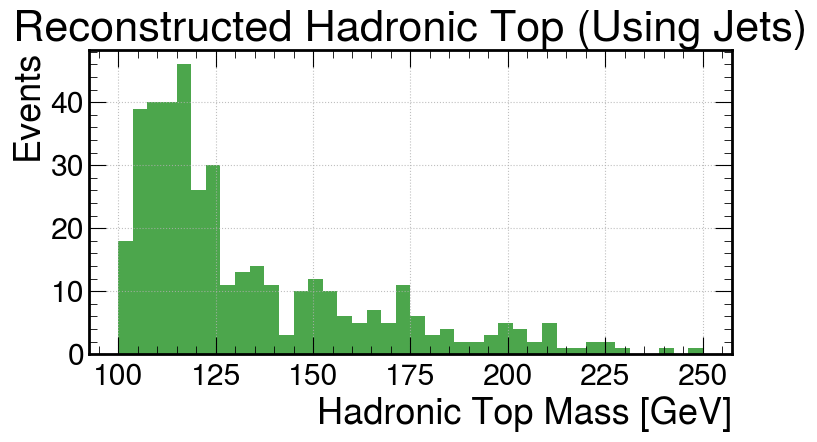

In [254]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(top_masses_had, bins=40, range=(100, 250), color='green', alpha=0.7)
plt.xlabel("Hadronic Top Mass [GeV]")
plt.ylabel("Events")
plt.title("Reconstructed Hadronic Top (Using Jets)")
plt.grid(True)
plt.tight_layout()
plt.show()


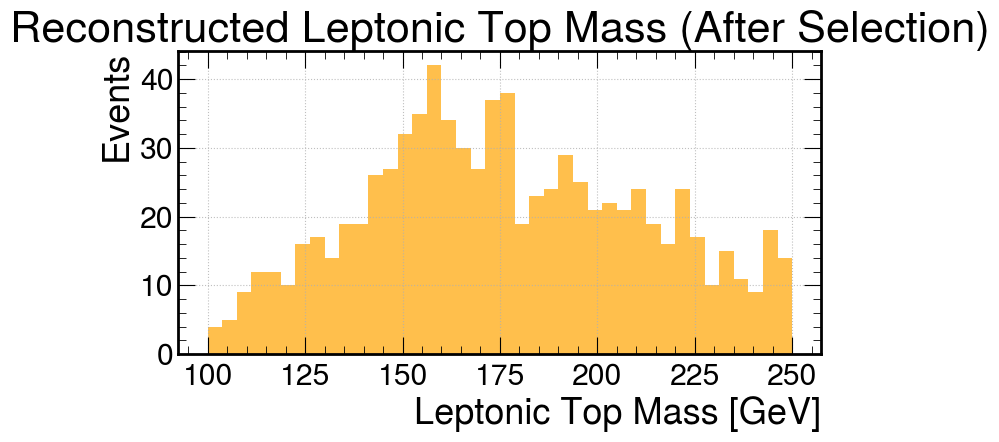

In [257]:
import numpy as np
import matplotlib.pyplot as plt

leptonic_top_masses = []

mW = 80.4  # W boson mass in GeV
mu_mass = 0.105
nu_mass = 0.0
b_mass = 4.8

# Loop over events
for i in range(len(df_ttbar_sel["Muon_Px"])):
    try:
        if len(df_ttbar_sel["Muon_Px"][i]) == 0:
            continue
        
        mu_px = df_ttbar_sel["Muon_Px"][i][0]
        mu_py = df_ttbar_sel["Muon_Py"][i][0]
        mu_pz = df_ttbar_sel["Muon_Pz"][i][0]
        mu_e  = np.sqrt(mu_px**2 + mu_py**2 + mu_pz**2 + mu_mass**2)

        met_px = df_ttbar_sel["MET_px"][i]
        met_py = df_ttbar_sel["MET_py"][i]

        a = 4 * (mu_e**2 - mu_pz**2)
        b = 4 * mu_pz * (mW**2 - 2 * (mu_px * met_px + mu_py * met_py))
        c = (mW**2 - 2 * (mu_px * met_px + mu_py * met_py))**2 - 4 * mu_e**2 * (met_px**2 + met_py**2)

        discriminant = b**2 - 4*a*c
        if discriminant < 0:
            continue

        sqrt_disc = np.sqrt(discriminant)
        pz_nu_1 = (-b + sqrt_disc) / (2*a)
        pz_nu_2 = (-b - sqrt_disc) / (2*a)

        for pz_nu in [pz_nu_1, pz_nu_2]:
            e_nu = np.sqrt(met_px**2 + met_py**2 + pz_nu**2 + nu_mass**2)

            if len(df_ttbar_sel["Jet_Px"][i]) < 1:
                continue
            b_px = df_ttbar_sel["Jet_Px"][i][-1]
            b_py = df_ttbar_sel["Jet_Py"][i][-1]
            b_pz = df_ttbar_sel["Jet_Pz"][i][-1]
            b_e  = df_ttbar_sel["Jet_E"][i][-1]

            top_px = mu_px + met_px + b_px
            top_py = mu_py + met_py + b_py
            top_pz = mu_pz + pz_nu  + b_pz
            top_e  = mu_e  + e_nu   + b_e

            m_top = np.sqrt(top_e**2 - top_px**2 - top_py**2 - top_pz**2)
            leptonic_top_masses.append(m_top)
    except:
        continue

# Plot
plt.figure(figsize=(8, 5))
plt.hist(leptonic_top_masses, bins=40, range=(100, 250), color='orange', alpha=0.7)
plt.xlabel("Leptonic Top Mass [GeV]")
plt.ylabel("Events")
plt.title("Reconstructed Leptonic Top Mass (After Selection)")
plt.grid(True)
plt.tight_layout()
plt.show()


TypeError: 'float' object is not subscriptable